In [1]:
import sys
import numpy as np
from astropy.io import fits
from aspired import image_reduction
from aspired import spectral_reduction

Install colorlog for colored logging output


In [2]:
# Line list
atlas = [
    4193.5, 4385.77, 4500.98, 4524.68, 4582.75, 4624.28, 4671.23, 4697.02,
    4734.15, 4807.02, 4921.48, 5028.28, 5618.88, 5823.89, 5893.29, 5934.17,
    6182.42, 6318.06, 6472.841, 6595.56, 6668.92, 6728.01, 6827.32, 6976.18,
    7119.60, 7257.9, 7393.8, 7584.68, 7642.02, 7740.31, 7802.65, 7887.40,
    7967.34, 8057.258
]
element = ['Xe'] * len(atlas)

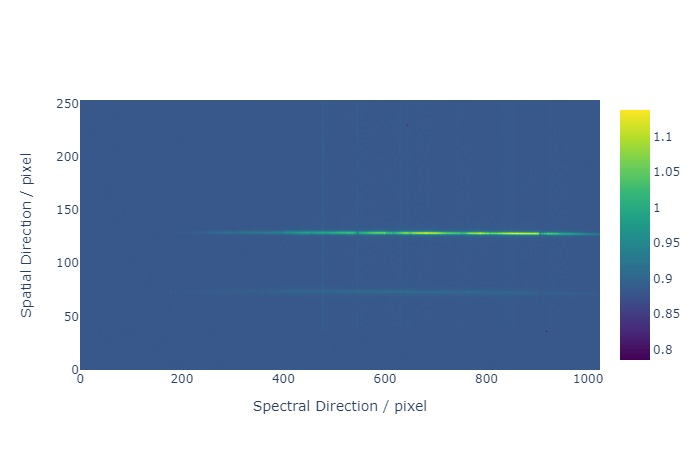

In [3]:
science_frame = image_reduction.ImageReduction('sprat_LHS6328.list')
science_frame.reduce()
science_frame.inspect(renderer='jpg')
#science_frame.savefits(overwrite=True)

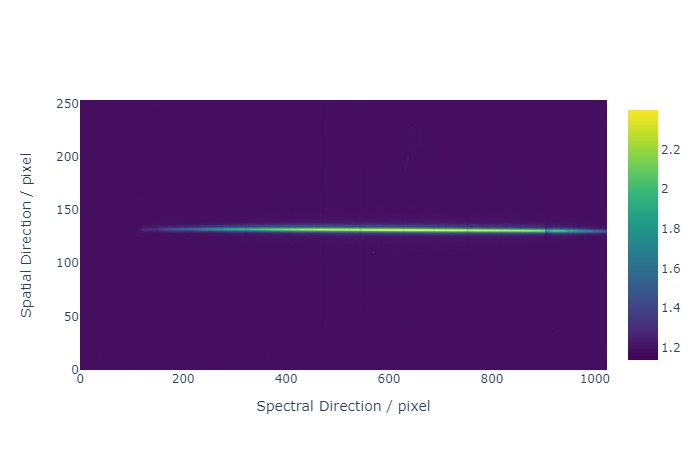

In [4]:
standard_frame = image_reduction.ImageReduction('sprat_Hiltner102.list')
standard_frame.reduce()
standard_frame.inspect(renderer='jpg')

In [5]:
# Set the spectral direction is defaulted to saxis=1
#saxis = 1

# initialise the two aspired.TwoDSpec()
lhs6328_twodspec = spectral_reduction.TwoDSpec(science_frame,
                                               cosmicray=True,
                                               readnoise=5.7)

hilt102_twodspec = spectral_reduction.TwoDSpec(standard_frame,
                                               cosmicray=True,
                                               readnoise=5.7)

ERROR:root:Please provide the variance in the same shape as the image.
ERROR:root:Please provide the variance in the same shape as the image.


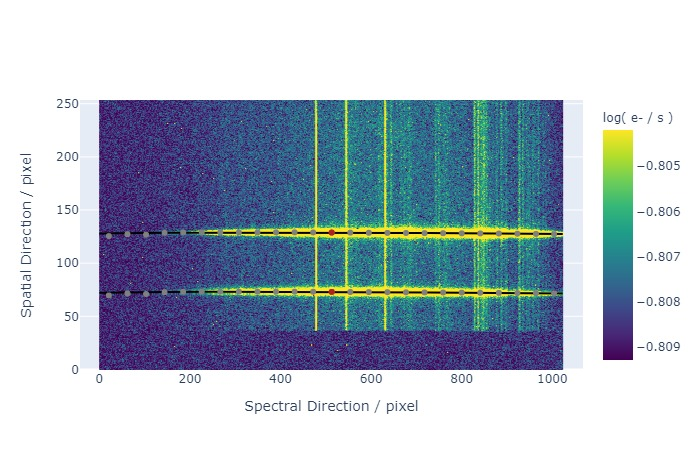

In [6]:
# automatically trace the spectrum
lhs6328_twodspec.ap_trace(nspec=2, display=True, renderer='jpg')

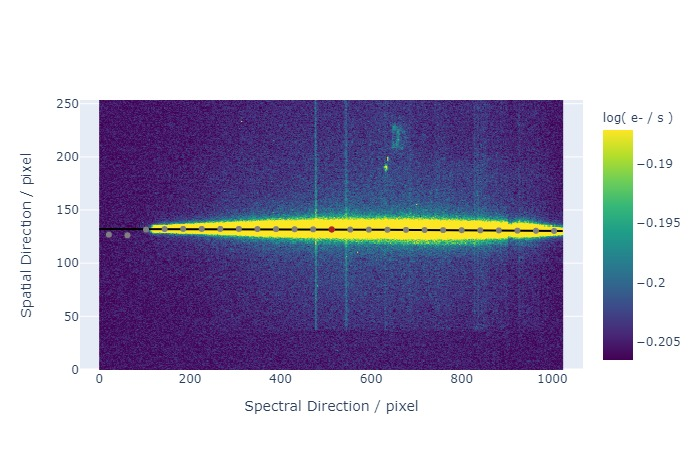

In [7]:
hilt102_twodspec.ap_trace(nspec=1, resample_factor=10, display=True, renderer='jpg')


invalid value encountered in sqrt



Input data contains invalid values (NaNs or infs), which were automatically clipped.




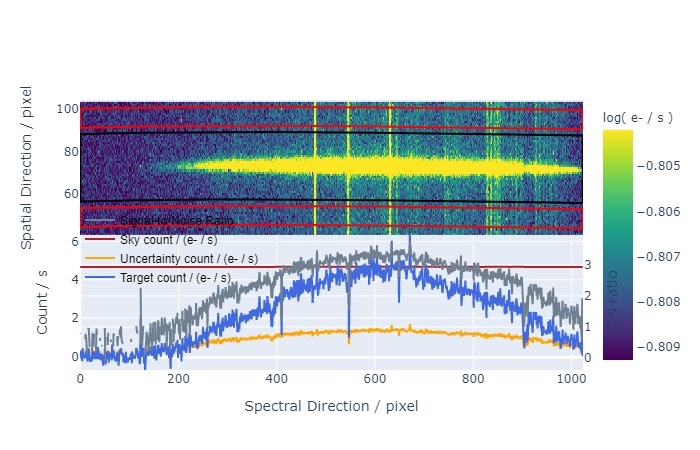


invalid value encountered in sqrt



Input data contains invalid values (NaNs or infs), which were automatically clipped.




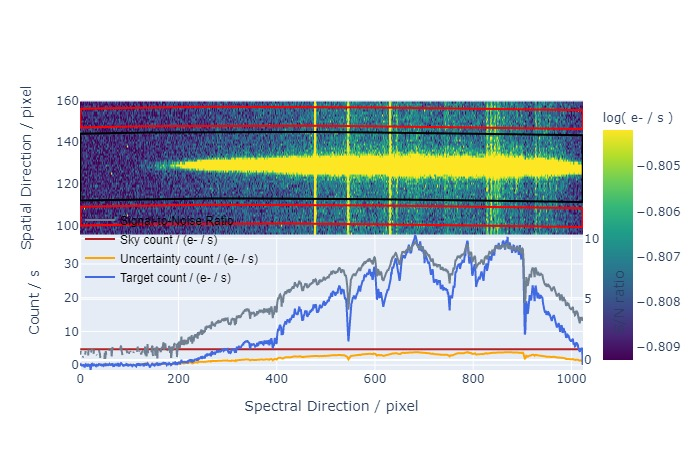

In [8]:
# Uncomment this to supply trace(s) manually, this overwrites the traces found with ap_trace.
# All these should work
#lhs6328_twodspe.add_trace([np.ones(1024)*130., np.ones(1024)*70.], 5.)
#lhs6328_twodspe.add_trace(np.ones(1024)*130., 5.)
#lhs6328_twodspe.add_trace([np.ones(1024)*130.], 5.)
#lhs6328_twodspe.add_trace([np.ones(1024)*130.], [5.])

# Optimal extracting spectrum by summing over the aperture along the trace
lhs6328_twodspec.ap_extract(apwidth=15,
                            skywidth=10,
                            skydeg=1,
                            optimal=False,
                            display=True,
                            save_iframe=False,
                            renderer='jpg')


invalid value encountered in true_divide



invalid value encountered in double_scalars



invalid value encountered in double_scalars



divide by zero encountered in true_divide



Input data contains invalid values (NaNs or infs), which were automatically clipped.



Input data contains invalid values (NaNs or infs), which were automatically clipped.




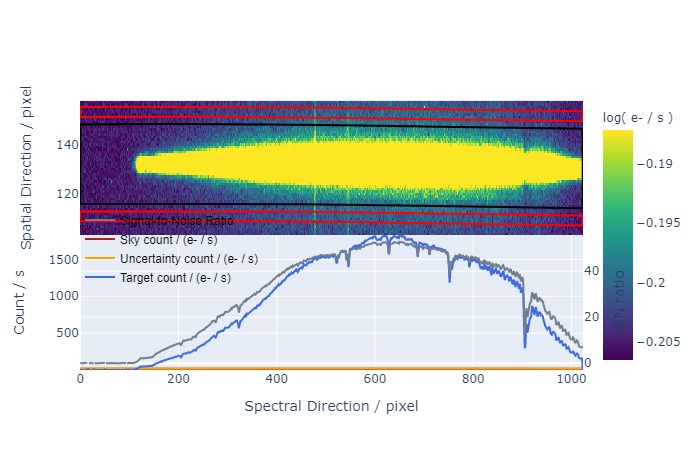

In [9]:
hilt102_twodspec.ap_extract(apwidth=15,
                            skysep=3,
                            skywidth=5,
                            skydeg=1,
                            optimal=True,
                            display=True,
                            save_iframe=True,
                            renderer='jpg')

In [10]:
# Extract the 1D arc by aperture sum of the traces provided
lhs6328_twodspec.extract_arc_spec(display=False, renderer='jpg')
hilt102_twodspec.extract_arc_spec(display=False, renderer='jpg')

In [11]:
lhs6328_onedspec = spectral_reduction.OneDSpec()
lhs6328_onedspec.from_twodspec(lhs6328_twodspec, stype='science')
# The standard extraction is identical to above, so we are reusing it
lhs6328_onedspec.from_twodspec(hilt102_twodspec, stype='standard')

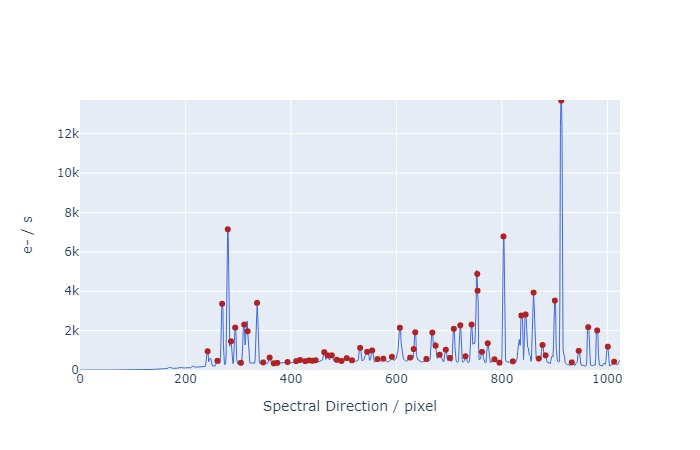

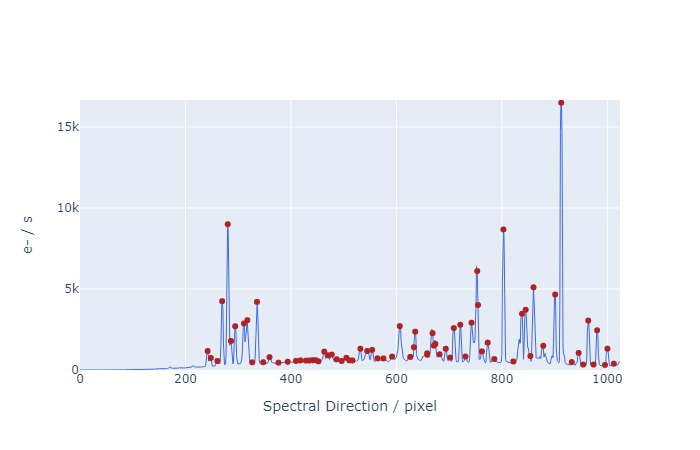

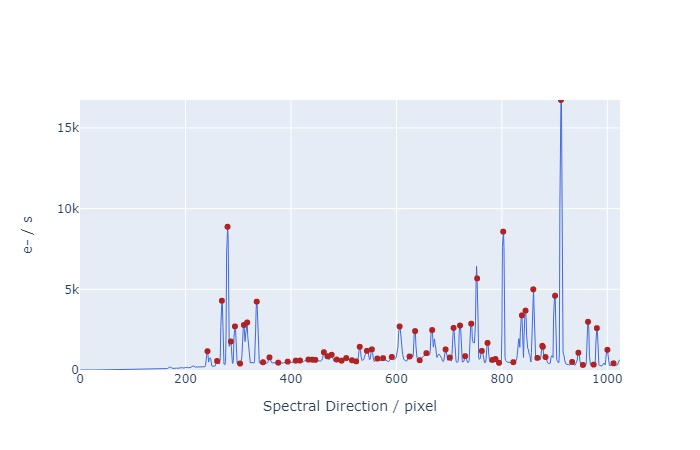

In [12]:
# Find the peaks of the arc
lhs6328_onedspec.find_arc_lines(display=True, stype='science+standard', renderer='jpg')

In [13]:
# Configure the wavelength calibrator
lhs6328_onedspec.initialise_calibrator(stype='science+standard')
lhs6328_onedspec.set_hough_properties(num_slopes=500,
                                      xbins=100,
                                      ybins=100,
                                      min_wavelength=3500,
                                      max_wavelength=8000,
                                      stype='science+standard')
lhs6328_onedspec.add_user_atlas(elements=element,
                                 wavelengths=atlas,
                                 stype='science+standard')
lhs6328_onedspec.do_hough_transform()

In [14]:
lhs6328_onedspec.fit(max_tries=500, stype='science', display=False)

Most inliers: 30, best error: 1.7682: 100%|██████████| 500/500 [00:38<00:00, 13.09it/s]


In [15]:
lhs6328_onedspec.add_fit_coeff(
    fit_coeff=lhs6328_onedspec.science_spectrum_list[0].fit_coeff,
    fit_type=lhs6328_onedspec.science_spectrum_list[0].fit_type,
    stype='standard')

In [16]:
lhs6328_onedspec.apply_wavelength_calibration(stype='science')
lhs6328_onedspec.apply_wavelength_calibration(stype='standard')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



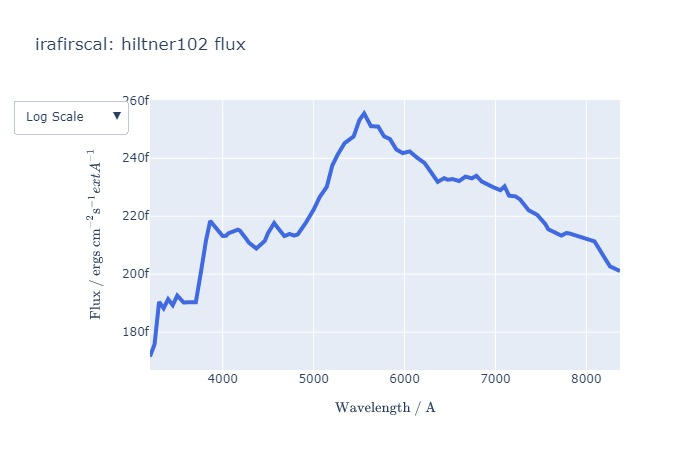

In [17]:
lhs6328_onedspec.load_standard(
    target='hiltner102',
    library='irafirs',
    cutoff=0.4,
    ftype='flux'
)
lhs6328_onedspec.inspect_standard(renderer='jpg')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



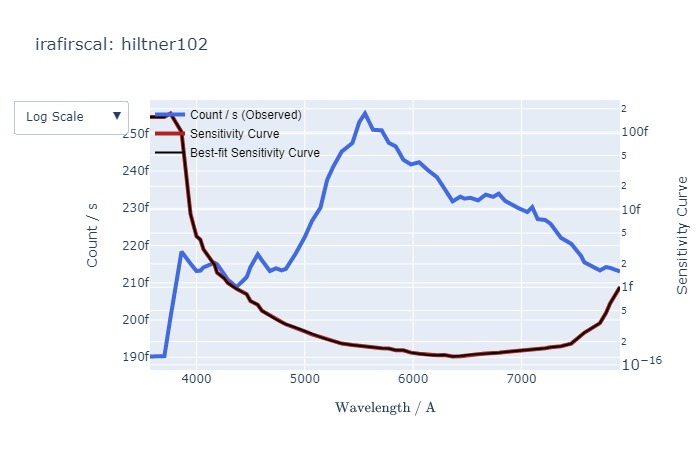

In [18]:
# Get the sensitivity curves
lhs6328_onedspec.compute_sensitivity(k=3)
lhs6328_onedspec.inspect_sensitivity(renderer='jpg')

In [19]:
lhs6328_onedspec.apply_flux_calibration(stype='science')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



In [20]:
lhs6328_onedspec.apply_flux_calibration(stype='standard')

In [21]:
lhs6328_onedspec.inspect_reduced_spectrum(stype='science')

In [22]:
lhs6328_onedspec.inspect_reduced_spectrum(stype='standard')